In [3]:
%matp
import numpy as np
import matplotlib.pyplot as plt
import math

# To Do for Sod Shock Tube:
- Fix boundary conditions
    - BC’s should be zero in normal velocity, Neumann in slip/tangential velocity
    - Check my boundary conditions so that the energy is a neumann condition
    - Check my boundary conditions so that density is neumann
- Try implementing the simpler flux splitting
- Check that my computation of the transformed values is correct


# DONE for sod shock tube:

- Update k values xi_x/J, xi_y/J for F, eta_x/J, eta_y/J for G., use k tilde equation from B4
- Initialize shock tube to zero velocity, should not obtain any divide by zero errors
- Update the initialization to the wikipedia initialization, this is dimensional
    - Use a pressure of 1 Pa, 10 Pa, rather than something reasonable, as this is a fake problem. Do it for validation
- implement actually reasonable time stepping based on Pramod's time step suggestions
    - Shock tube delta t: should be obtained from the maximum of the eigenvalues, not as a fixed dt = 0.4*dx.
    - Multiply time step from eigenvalues by 0.1 or 0.2 for the CFL- implement actually reasonable time stepping based on Pramod's time step suggestions
    - Shock tube delta t: should be obtained from the maximum of the eigenvalues, not as a fixed dt = 0.4*dx.
    - Multiply time step from eigenvalues by 0.1 or 0.2 for the CFL


# To Do for Airfoil Problem

- Separate the mesh metrics function out, to be called in any arbitrary grid generation function
- Make grid generation function for 4:1 ellipse in x/y and xi/eta space
    - sponge layer, make it more coarse as it goes out (scaling with r) so the elements stay roughly square
    - $x = \cosh(\eta)*\cos(\xi) \to x = \cosh()$
    - 50 chord lengths away in all directions
    - make the mesh finer at the base, so that I can use the same mesh for viscous (target y+ of 1)
- When doing the initialization of U for the elliptical wing, look at the photo Ricardo sent me
- FOR THE ELLIPSE, WRAP IN A CLOCKWISE ORDER. DON’T KNOW WHY THIS IS IMPORTANT, BUT IT IS APPARENTLY VERY IMPORTANT. OTHERWISE, YOU RUN INTO COMPLEX ERRORS.
- Update Jacobian J
- Create initialization for the mesh
- Create function to apply boundary conditions for the problem
- Check that all my indexing is correct, appropriate
- Determine a reasonable time step
- Make plots

# Sod Shock Tube Problem

Step 1: Create mesh

Step 2: Split Fluxes, simple and Steger-Warming methods, in order to do upwinding

Step 3: Initialize the values of rho, u, v, p throughout the problem 

Step 4: Apply explicit euler time stepping

Note that tildes are used for the values that are transformed in to $\xi$ and $\eta$ space.

# Prep plotting functions!

For the sod shock tube, we want a plot of rho/rho0 vs x.

In [1249]:
def plot2var(x,y,xlabel='x',ylabel='rho/rho_0',filename=[]):
    plt.figure(figsize=(10,5))
    axes_internal = plt.gca()
    axes_internal.set_xlabel(xlabel)
    axes_internal.set_ylabel(ylabel)
    plt.title(ylabel + ' vs ' + xlabel)
    plt.plot(x,y)
    if len(filename) != 0:
        plt.savefig('FinalProject_' + filename + '.png')
    plt.show()
    
    
def PlotJacobian(x,y,J,levels=5,filename=[],printvals=True):
    # xgrid, ygrid = np.meshgrid(x,y)
    # print(xgrid)
    # print(ygrid)
    
    
    # Assuming x, y, J, all have the same shape
    S1, S2 = np.shape(x)
    if filename == 'Sod_Shock_Tube':
        x = x[1:S1-1,1:S2-1]
        y = y[1:S1-1,1:S2-1]
        J = J[1:S1-1,1:S2-1]
    elif filename == 'Elliptical_Wing':
        J[:,S2-1] = J[:,1] # wrap J in xi, where the coordinates are (eta row, xi column)
        x = x[1:S1-1,1:S2]
        y = y[1:S1-1,1:S2]
        J = J[1:S1-1,1:S2]
    
    if printvals:
        print(x)
        print(y)
        print(J)
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x,y,J)
    plt.xlabel('x')
    plt.ylabel('y')
    if len(filename) != 0:
        plt.savefig('FinalProject_' + filename + '_MeshScatter.png')
    plt.show()
    
    plt.figure()
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(x,y,J) #light blue
    plt.title('Jacobian 3D Plot ' + filename)
    plt.xlabel('x')
    plt.ylabel('y')
    if len(filename) != 0:
        plt.savefig('FinalProject_' + filename + '_Jacobian3D.png')
    plt.show()
    
    plt.figure()
    cp = plt.contourf(x, y, J, levels)#, colors='black', linestyles='dashed')
    # plt.clabel(cp, inline=True, fontsize=10)
    plt.title('Jacobian Contour: ' + filename)
    plt.xlabel('x')
    plt.ylabel('y')
    if len(filename) != 0:
        plt.savefig('FinalProject_' + filename + '_JacobianContour.png')
    plt.show()
    
    return None




# Compute Mesh Metrics

Given any 2D mesh, we want to be able to compute the mesh metrics. We can numerically compute the derivatives of $x$ and $y$ with respect to $\xi$ and $\eta$:

$$x_\xi = \frac{x_{i+1}-x_{i-1}}{\xi_{i+1}-\xi_{i-1}}$$

We can write the transformation of derivatives in $x$, $y$ to $\xi$, $\eta$ as follows:

$$\begin{pmatrix}
\frac{\partial}{\partial \xi}\\
\frac{\partial}{\partial \eta}
\end{pmatrix} = \begin{pmatrix}
x_\xi & y_\xi\\
x_\eta & y_\eta
\end{pmatrix}\begin{pmatrix}
\frac{\partial}{\partial x}\\
\frac{\partial}{\partial y}
\end{pmatrix}
$$

We define:

$$T = \begin{pmatrix}
x_\xi & x_\eta\\
y_\xi & y_\eta
\end{pmatrix}$$

Thus, we have:

$$T^{-1} = \begin{pmatrix}
\xi_x & \xi_y\\
\eta_x & \eta_y
\end{pmatrix}$$

By performing the matrix inversion from the definition of $T$, we have:
$$T^{-1} = J \begin{pmatrix} 
y_\eta & -x_\eta \\
- y_\xi & x_\xi
\end{pmatrix} = \begin{pmatrix}
\xi_x & \xi_y \\
\eta_x & \eta_y
\end{pmatrix}$$

In [1238]:
def meshmetrics(numxint,numyint,numghosts,coords):
    Ni = numxint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    Nj = numyint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    
    # COMPUTING MESH METRICS
    
    # unpack x, y, xi, eta, from gridcoords
    x = coords[:,:,0]
    y = coords[:,:,1]
    xi = coords[:,:,2]
    eta = coords[:,:,3]
    
    # Initialize derivatives of x,y
    # This could be a separate function meshmetric(x,y,xi,eta)
    dxdxi = np.zeros((Nj,Ni)) # size based on number of xi values (91)
    dxdeta = np.zeros((Nj,Ni)) # size based on the number of eta values (2)
    dydxi = np.zeros((Nj,Ni))
    dydeta = np.zeros((Nj,Ni))
    # Initialize J
    J = np.zeros((Nj,Ni))
    # Initialize derivatives of xi,eta
    dxidx = np.zeros((Nj,Ni))
    detadx = np.zeros((Nj,Ni))
    dxidy = np.zeros((Nj,Ni))
    detady = np.zeros((Nj,Ni))
    for i in range(1,numxint+1): 
        for j in range(1,numyint+1):
            # derivatives of x,y wrt xi,eta
            dxdxi[j,i] = (x[j,i+1] - x[j,i-1])/(xi[j,i+1]-xi[j,i-1]) # 0.05
            dxdeta[j,i] = (x[j+1,i] - x[j-1,i])/(eta[j+1,i]-eta[j-1,i]) # 0
            dydxi[j,i] = (y[j,i+1] - y[j,i-1])/(xi[j,i+1]-xi[j,i-1]) # 0
            dydeta[j,i] = (y[j+1,i] - y[j-1,i])/(eta[j+1,i]-eta[j-1,i]) # 1
            # print('------')
            # print(y[j+1,i])
            # print(y[j-1,i])
            # print(eta[j+1,i])
            # print(eta[j-1,i])
            #Jacobian of transformation, J
            J[j,i] = 1/(dxdxi[j,i]*dydeta[j,i]-dxdeta[j,i]*dydxi[j,i])
            #derivatives of xi,eta wrt x,y (comes from inverting the transformation matrix)
            dxidx[j,i] = J[j,i] * dydeta[j,i]
            dxidy[j,i] = -J[j,i] * dxdeta[j,i]
            detadx[j,i] = -J[j,i] * dydxi[j,i]
            detady[j,i] = J[j,i] * dxdxi[j,i]
    coords[:,:,4] = dxidx
    coords[:,:,5] = detadx
    coords[:,:,6] = dxidy
    coords[:,:,7] = detady
    coords[:,:,8] = J
    # Note that the derivatives of xi, eta wrt x,y are nan in the edges. 
    
    return coords

# Create meshes in x, y, $\xi$, $\eta$

This should be a function, so that I can choose what mesh to read into my solver -- a sod shock tube mesh, or a 4:1 elliptical airfoil mesh, or a NACA mesh!

Make sure that my $\Delta\xi$ and $\Delta\eta$ values between points is always 1!!!!

Be very, very careful if I change the number of ghosts on one side only -- this will make it so that my indexing will change in the flux computation, and also my x and y values will not have that point either before or after...

Would probably be better programming practice to fully pull the function call to meshmetrics out of this mesh creation function, but I've already written the rest of the program assuming all the grid info and mesh metrics are packaged together, so I'll put a meshmetrics function call inside of each grid generation function.

dx = 0.1111111111111111
dy = 1.0
[[-0.11111111  0.          0.11111111  0.22222222  0.33333333  0.44444444
   0.55555556  0.66666667  0.77777778  0.88888889  1.          1.11111111]
 [-0.11111111  0.          0.11111111  0.22222222  0.33333333  0.44444444
   0.55555556  0.66666667  0.77777778  0.88888889  1.          1.11111111]
 [-0.11111111  0.          0.11111111  0.22222222  0.33333333  0.44444444
   0.55555556  0.66666667  0.77777778  0.88888889  1.          1.11111111]
 [-0.11111111  0.          0.11111111  0.22222222  0.33333333  0.44444444
   0.55555556  0.66666667  0.77777778  0.88888889  1.          1.11111111]]
[[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
 [ 0.  1.  2

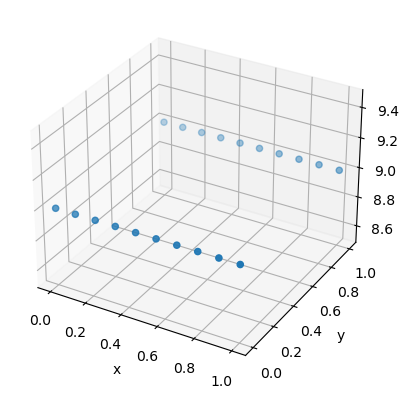

<Figure size 640x480 with 0 Axes>

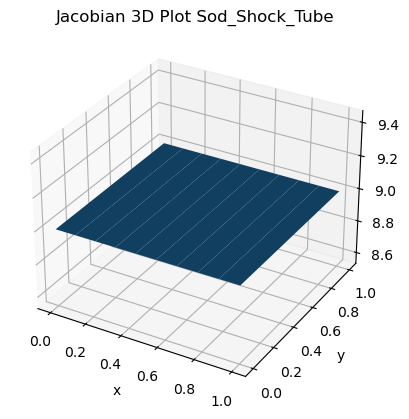

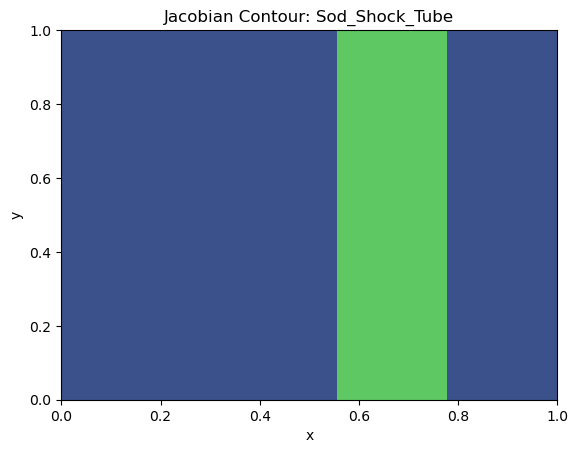

In [1239]:
def regxygrid(numxint,numyint,numghosts, L, H):
    # numxint is the number of internal points in i. Number of intervals is numpts-1.
    # numyint is the number of internal points in j. Number of intervals is numpts-1.
    
    # This calculation is copied in main() rather than passing more info to the function
    # Probably a bad design decision, make these inputs to the function
    # total number of points in each direction
    Ni = numxint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    Nj = numyint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    
    dx = L/(numxint-1) # num cells = numpoints-1
    dy = H/(numyint-1) # because this problem is 1D, this is somewhat arbitrary. Set dy = 1.
    print('dx = ' + str(dx))
    print('dy = ' + str(dy))
    
    
    xi = np.zeros((Nj,Ni))
    eta = np.zeros((Nj,Ni))
    for i in range(Ni):
        for j in range(Nj):
            xi[j,i] = i
            eta[j,i] = Nj-j-1
    # The reason I use two for loops instead of np.arange 
    # is that I don't want to write a for loop to copy one vector many times, since xi and eta are the same.
    # This is inefficient storage-wise, but it works nicely to make all the data have the same 2D format.

    x = (xi-numghosts)*dx # for this particular mesh, where x=xi (but then subtract the ghosts)
    y = (eta-numghosts)*dy # y=eta (but subtract the ghosts)

    
    # print(xi)
    # print(eta)
    # print(x)
    # print(y)
    
    coords = np.zeros((Nj,Ni,9)) # Nj rows, Ni columns, 9 layers
    coords[:] = np.nan
    # coords[:] = 27
    # Note that any value that is not filled will default to zero. 
    # This can be dangerous, so I fill all the unused values with NaN's
    
    # coords[0:Nj,0:Ni,0] = x
    coords[:,:,0] = x 
    coords[:,:,1] = y
    coords[:,:,2] = xi
    coords[:,:,3] = eta
    # Note that this includes values of coordinates for the ghost cells
    
    coords = meshmetrics(numxint,numyint,numghosts,coords) #note that the slice indexing excludes the last value

    # coords contains an array for each of x, y, xi, and eta, and derivatives of xi and eta. 
    # Each specific value can be accessed by indices i,j.
    # For x, coords[j,i,0]=xval, coords[j,i,1] = yval, coords[j,i,2]=xival, coords[j,i,3]=etaval.
    # coords[j,i,4] = dxidx, coords[j,i,5] = detadx, coords[j,i,6] = dxidy, coords[j,i,7] = detady, coords[j,i,8] = J
    return coords

sodshockgrid = regxygrid(numxint=10,numyint=2,numghosts=1,L=1,H=1)
# For sod shock tube, L = 4.5. H = 1 for arbitrary convenience, dx = 1.0
# Note that x=1.95 is the boundary between points. Potentially want to make it so no points lie there?
# x=1.95 is halfway between points? 

# sodshockgrid(j, i, quantity index)
x = sodshockgrid[:,:,0]
print(x) # x
y = sodshockgrid[:,:,1]
print(y) # y
print(sodshockgrid[:,:,2]) # xi
print(sodshockgrid[:,:,3]) # eta
print(sodshockgrid[:,:,4]) # dxidx
print(sodshockgrid[:,:,5]) # detadx
print(sodshockgrid[:,:,6]) # dxidy
print(sodshockgrid[:,:,7]) # detady
J = sodshockgrid[:,:,8]
print(J) # J

print('--------------------')

PlotJacobian(x,y,J,levels=1,filename = 'Sod_Shock_Tube')

# Define Global Variables

Some variables will be global constants throughout the problem. We define these constants here:

In [1191]:
gamma = 1.4
p_infty = 1/gamma
rho_infty = 1
c_infty = 1 # math.sqrt(gamma*p_infty/r_infty)

# Note that these values are nondimensionalized. 
# If we want to solve a real problem, we can choose some physical values for p and rho infty.

# Explicit Euler Time Stepping

$$U_{i,j}^{n+1} = U_{i,j}^n - \Delta t * J_{i,j}*R_{i,j}$$

Note that $U_{i,j}$ is a 1D array at each point in space, and so the full $U$ throughout the 2D domain at time $t$ is a 3D array. Similarly, $R_{i,j}$ is a 1D array at each point in space, and so the full $R$ throughout the 2D domain at time $t$ is a 3D array.

Computing $U_{i,j}^{n+1}$ requires us to initialize $U_{i,j}^n$, pick a stable time step $\Delta t$, compute the jacobian of our mesh transformation $J$, and the quantity $R$, which in turn requires us to obtain the spatial derivatives of $\tilde{F}$ and $\tilde{G}$ using upwinding and flux vector splitting.

One question: Where does the upwinding come into play? We can compute $F^+$ and $F^-$ if we really want to, but where does this come in?

Answer: This comes into play when we compute the spatial derivative. We upwind with $F^-$ and downwind with $F^+$ (if i recall correctly).

In [1154]:
def expeuler(u,dt,J,R,Ni,Nj,numghosts):
    uk1 = np.full_like(u,0)
    for i in range(numghosts,Ni-numghosts):
        for j in range(numghosts,Nj-numghosts):
            uk1[j,i,:] = u[j,i,:] - dt*J[j,i]*R[j,i,:]
    return uk1

# Computing Fluxes

In order to compute the derivatives of $\tilde{F}$ and $\tilde{G}$, we need to compute the derivatives $A$ and $B$ with respect to $U$:

$$\frac{\partial U}{\partial t} + \frac{\partial F}{\partial \xi} + \frac
{\partial G}{\partial \eta}=0$$
$$\frac{\partial U}{\partial t} + \frac{\partial F}{\partial U}\frac{\partial U}{\partial \xi} + \frac
{\partial G}{\partial U}\frac{\partial U}{\partial \eta}=0$$
$$\frac{\partial U}{\partial t} + A \frac{\partial U}{\partial \xi} + B \frac{\partial U}{\partial \eta}=0$$

Note that:
$$F = AU$$




Then, if we assume $A$ is constant in space, $\frac{\partial F}{\partial \xi} =A  \frac{\partial U}{\partial \xi}$. Otherwise, $\frac{\partial F}{\partial \xi} =A  \frac{\partial U}{\partial \xi} + \frac{\partial A}{\partial \xi}U$. 

To start, let's compute $A$ and $B$:


HOLD UP:
We actually don't need to compute these, because Steger and Warming have already done it for us. They also took these matrices, found the eigenvector/eigenvalue decomposition, split the eigenvalues into the + and - components, and multiplied the right eigenvector matrix by the eigenvalue+/- matrices and the left eigenvector matrix, and computed the generalized flux vector. This result is what we will compute, for the sake of me saving time right now. Later, I can come back and determine A and B, and then the eigendecompositions, and then perform the matrix multiplication $Q*lambda*Qinv*U$, and then obtain the generalized flux vector that Steger and Warming obtained.


In order to compute these derivatives in a compressible flow where there may be some shockwaves, we should upwind appropriately. To do this, we use Steger and Warming's flux vector splitting method, in particular, see equation B9 in their paper.


We also use k1 and k2 as the derivatives of xi and eta wrt x and y, divided by J. We use xi derivatives for F and eta diervatives for G. This is because equation B1 is analogous to the equation in the assignment for Ftilde and Gtilde.

In [1155]:
def fluxpm(fg,plusminus,U,xi_x,xi_y,eta_x,eta_y,J,smoothing=True): # Take in the xi, eta derivatives as well
    # Note that here, U is a vector for the particular i,j that we are computing fluxes at
    if fg == 'F':
        k1 = xi_x/J
        k2 = xi_y/J
    elif fg == 'G':
        k1 = eta_x/J
        k2 = eta_y/J
        
    # These equations B4 in Steger and Warming are required for k1 and k2 not equal to 0,1 or 1,0. 
    # However, for my rectangular grid with dy = 1, these will be 1,0 
    k1t = k1/(k1**2+k2**2)**(1/2)
    k2t = k2/(k1**2+k2**2)**(1/2)
    # print('-----')
    # print(k1t)
    # print(k2t)
    
    rho = U[0] # rho
    u = U[1]/U[0] # rho*u/rho = u
    v = U[2]/U[0] # rho*v/rho = v
    p = (gamma-1)*U[3]
    c = math.sqrt(gamma*p/rho)
    # Note that gamma is a global variable, but c is a local variable
    
    # this is somewhat wasteful in terms of computations.
    # the generalized flux vector requires more computations than the flux vector 
    # for each individual F/G would require. However, this is easier to implement.
    # It also means I don't have to define as many functions.
    l1 = k1t*u + k2t*v 
    l3 = l1 + c*(k1t**2+k2t**2)**(1/2) # Note that this is equal to l1+c for all values of interest
    l4 = l1 - c*(k1t**2+k2t**2)**(1/2) # Note that this is equal to l1-c for all values of interest
    
    # The "smoothing"
    if smoothing:
        l1 = smoothlambda(l1,plusminus)
        l3 = smoothlambda(l3,plusminus)
        l4 = smoothlambda(l4,plusminus)
    else:
        l1 = roughlambda(l1,plusminus)
        l3 = roughlambda(l3,plusminus)
        l4 = roughlambda(l4,plusminus)
    
    fluxvec = np.zeros((4,1)) # 4 rows, 1 column
    
    fluxvec[0] = 2*(gamma-1)*l1+l3+l4
    fluxvec[1] = 2*(gamma-1)*l1*u + l3*(u+c*k1t) + l4*(u-c*k1t)
    fluxvec[2] = 2*(gamma-1)*l1*v + l3*(v+c*k2t) + l4*(v-c*k2t)
    fluxvec[3] = (gamma-1)*l1*(u**2+v**2) + l3/2*((u+c*k1t)**2 + (v+c*k2t)**2) + \
    l4/2*((u-c*k1t)**2 + (v-c*k2t)**2) + (3-gamma)*(l3+l4)*c**2/(2*(gamma-1))
    fluxvec = rho/(2*gamma) * fluxvec
    return fluxvec
    
        
    
def smoothlambda(lambdaval,plusminus=[]):
    ep = 0.01 # not sure if this is a good value... should try some different ones?
    if plusminus == 'plus':
        lpm = (lambdaval + math.sqrt(lambdaval**2+ep**2))/2
    elif plusminus == 'minus':
        lpm = (lambdaval - math.sqrt(lambdaval**2+ep**2))/2
    return lpm

def roughlambda(lambdaval,plusminus=[]):
    if plusminus == 'plus':
        lpm = (lambdaval + abs(lambdaval))/2
    elif plusminus == 'minus':
        lpm = (lambdaval - abs(lambdaval))/2
    return lpm

# Flux Derivatives


We have from Pramod's slides "evec" that the formulation of explicit Euler we are to use is given with the following definition of a quantity $R$:

$$R_{i,j} = \left(\frac{\partial\tilde{F}}{\partial\xi} + \frac{\partial\tilde{G}}{\partial\eta}\right)_{i,j}$$



Recall from the assignment that we can implement upwinding as follows for Steger and Warming's flux splitting method:

$$\frac{\partial \tilde{F}}{\partial \xi} \approx \frac{\tilde{F}_i^+ - \tilde{F}_{i-1}^+}{\Delta \xi} + \frac{\tilde{F}_{i+1}^- - \tilde{F}_{i}^-}{\Delta \xi} $$

$$\frac{\partial \tilde{G}}{\partial \eta} \approx \frac{\tilde{G}_i^+ - \tilde{G}_{i-1}^+}{\Delta \eta} + \frac{\tilde{G}_{i+1}^- - \tilde{G}_{i}^-}{\Delta \xi} $$

In order to get the $\tilde{F}$ and $\tilde{G}$ values, we have to apply the following computations:

$$\tilde{F}^+ = \frac{\xi_x}{J}F^+ + \frac{\xi_y}{J}G^+$$
$$\tilde{F}^- = \frac{\xi_x}{J}F^- + \frac{\xi_y}{J}G^-$$
$$\tilde{G}^+ = \frac{\eta_x}{J}F^+ + \frac{\eta_y}{J}G^+$$
$$\tilde{G}^- = \frac{\eta_x}{J}F^- + \frac{\eta_y}{J}G^-$$




$$R_{i,j} = \left(\frac{\partial\tilde{F}}{\partial x} + \frac{\partial\tilde{G}}{\partial y}\right)_{i,j}$$





In [1156]:
def getR(U,numghosts,sodshockgrid,Ni,Nj): 
    # THIS SHOULD include the xi, eta derivatives evaluated as a function of space.
    # Perhaps they should be evaluated inside the i, j for loop
    # Try: create a function that gets derivative of xi, eta wrt x,y
    # inputs (x,y) grid and (xi,eta) grid
    # Evaluate inside this loop
    
    
    dGdeta = np.full_like(U,0)
    dFdxi = np.full_like(U,0)
    Rmatr = np.full_like(U,0)
    for i in range(numghosts,Ni-numghosts): # NEED TO EXCLUDE THE GHOST CELLS
        # print('i = ' + str(i))
        for j in range(numghosts,Nj-numghosts): # NEED TO EXCLUDE THE GHOST CELLS
            # print('j = ' + str(j))
            # obtain xi, eta derivatives here instead of making them globals
            # These will be identically equal for most values in the regular sod shock grid, but
            # not for the curvilinear grid.
            xi_x = sodshockgrid[j,i,4]
            xi_y = sodshockgrid[j,i,6]
            eta_x = sodshockgrid[j,i,5]
            eta_y = sodshockgrid[j,i,7]
            J = sodshockgrid[j,i,8]
            
            # MAKE FLUX CALCULATIONS TAKE IN XI, ETA DERIVATIVE VALUES AS WELL
            
            # F values
            Fpl = fluxpm('F','plus',U[j,i],xi_x,xi_y,eta_x,eta_y,J,smoothing=True)
            Flopl = fluxpm('F','plus',U[j,i-1],xi_x,xi_y,eta_x,eta_y,J,smoothing=True) #F_{i-1}^+ (lo plus)
            Fhimi = fluxpm('F','minus',U[j,i+1],xi_x,xi_y,eta_x,eta_y,J,smoothing=True) #F_{i+1}^- (hi minus)
            Fmi = fluxpm('F','minus',U[j,i],xi_x,xi_y,eta_x,eta_y,J,smoothing=True)
            
            # G values
            Gpl = fluxpm('G','plus',U[j,i],xi_x,xi_y,eta_x,eta_y,J,smoothing=True)
            Glopl = fluxpm('G','plus',U[j-1,i],xi_x,xi_y,eta_x,eta_y,J,smoothing=True) #G_{j-1}^+ (lo plus)
            Ghimi = fluxpm('G','minus',U[j+1,i],xi_x,xi_y,eta_x,eta_y,J,smoothing=True) #G_{j+1}^- (hi minus)
            Gmi = fluxpm('G','minus',U[j,i],xi_x,xi_y,eta_x,eta_y,J,smoothing=True)
            
            # Tilde F values
            tFpl = xi_x/J*Fpl + xi_y/J*Gpl
            tFlopl = xi_x/J*Flopl + xi_y/J*Glopl
            tFhimi = xi_x/J*Fhimi + xi_y/J*Ghimi
            tFmi = xi_x/J*Fmi + xi_y/J*Gmi
            
            # Tilde G values
            tGpl = eta_x/J*Fpl + eta_y/J*Gpl
            tGlopl = eta_x/J*Flopl + eta_y/J*Glopl
            tGhimi = eta_x/J*Fhimi + eta_y/J*Ghimi
            tGmi = eta_x/J*Fmi + eta_y/J*Gmi
            
            # Compute derivatives
            dFdxicol = (tFpl - tFlopl) + (tFhimi - tFmi) # d tilde F d xi
            dFdxivec = np.reshape(dFdxicol,(-1))
            dFdxi[j,i,:] = dFdxivec
            dGdetacol = (tGpl - tGlopl) + (tGhimi - tGmi) # d tilde G d eta
            dGdetavec = np.reshape(dGdetacol,(-1))
            dGdeta[j,i,:] = dGdetavec
            # NOTE THAT I ASSUME DELTA ETA AND DELTA XI BOTH EQUAL 1
            # print('----------')
            # print(tFpl-tFlopl)
            # print('--')
            # print(tFhimi-tFmi)
    # Compute R
    R = dFdxi + dGdeta
    # R should be non-zero where ever there are gradients of U.
    return R

# NEED TO TEST THAT THIS DOES NOT FILL GHOST CELLS FOR R.
# This will result in an out of bounds error (since there are no i-1 and/or i+1 points next to ghost cells)

# Initialize Solution

Note that pleft = 1 Pa, pright = 0.1 Pa. u and v are initialized to 0. Rho is initialized to 1 and 0.125.

Recall that:
$$\rho E =  \frac{(u^2 + v^2 )}{2} + \rho\frac{p}{\gamma-1}$$
NOT SURE IF THIS EQUATION IS RIGHT OR NOT. CHECK 7.3 VS PRAMOD'S SLIDES

Because the velocities are zero to start, this means that if $\gamma=1.4$, $\rho E$ left is $\rho_l*\frac{1}{0.4}=1*2.5 = 2.5$, and $\rho E$ right is $\rho_r*\frac{0.1}{0.4}=0.125*0.25 = 0.03125$

<!-- We'll try rho as 3 kg/m$^3$, roughly 3x the 1.225 that is standard for air, to get the high density behavior. -->


In [1053]:
def sodinitial(gridinfo,numxint,numyint,numghosts):
    xvals = gridinfo[:,:,0]
    Ni = numxint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    Nj = numyint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    # 4 quantities per point (i,j)
    # 0 is rho
    # 1 is rho*u
    # 2 is rho*v
    # 3 is rho*E
    Uinitial = np.zeros((numyint+2*numghosts,numxint+2*numghosts,4))
    Uinitial[:,:,:] = np.nan
    for i in range(1,numxint+1): # +1 because range excludes final point
        for j in range(1,numyint+1): # +1 because range excludes final point
            if xvals[j,i] <= 0.5:
                # Uinitial[j,i] = np.array([10, 0, 0, 10**6])
                Uinitial[j,i,:] = np.array([1, 0, 0, 2.5]) # CHECK THAT INITIALIZATION VALUES OF RHO ARE CORRECT FOR THE FORMULA. PRESSURE SHOULD BE 0.1 AND 1, NOT ENERGY
            else:
                # Uinitial[j,i] = np.array([10, 0, 0, 10**7])
                Uinitial[j,i,:] = np.array([0.125, 0, 0, 0.031225]) # For Pramod's equation of state, rhoE should just be p/0.4 = 0.25...
    # I do want to plot these quantities, just to make sure I did it right... 
    # add plotting functionality above that plots density, u, v, and pressure vs x
    # plot(rho/rho0 vs x)
    # print(xvals[1,1:Ni])
    # print(Uinitial[1,1:Ni-1,0])
    plot2var(xvals[1,1:Ni],Uinitial[1,1:Ni,0]) # Uinitial[interior,0], divided by rho0=1 for the higher density value
    # plot2var(xvals[1,1:Ni],Uinitial[1,1:Ni,3]*0.3,xlabel='x',ylabel='pressure')
    return Uinitial

# Apply Boundary Conditions

In [1054]:
def FillSodShockBCs(U,Ni,Nj,printvals=False):
    if printvals:
        print('------')
        print('input of Fill BCs')
        print(U[:,:,1])
    
    # Could maybe do this more efficiently by doing row 1 and row 2 for u and v together using slicing? U[:,0,1:3] = p
    # To revert to original all neumann BC, just set the third index to a : and use only one assignment
    
    # 1st column, x=-dx
    U[:,0,0] = U[:,1,0]
    U[:,0,1] = 0
    U[:,0,2] = U[:,1,2] # should allow v for the left and right BCs for slip walls (inviscid).
    U[:,0,3] = U[:,1,3]
    
    
    # last column, x = L + dx
    U[:,Ni-1,0] = U[:,Ni-2,0]
    U[:,Ni-1,1] = 0
    U[:,Ni-1,2] = U[:,Ni-2,2]# should allow v for the left and right BCs for slip walls (inviscid).
    U[:,Ni-1,3] = U[:,Ni-2,3]
    
    
    # top row, y=H+dy
    U[0,:,0] = U[1,:,0]
    U[0,:,1] = U[1,:,1] # should allow u for the top and bottom BCs for slip walls (inviscid).
    U[0,:,2] = 0
    U[0,:,3] = U[1,:,3]
    
    # bottom row, y = -dy
    U[Nj-1,:,0] = U[Nj-2,:,0] 
    U[Nj-1,:,1] = U[Nj-2,:,1]  # Should allow u for the top and bottom BCs for slip walls (inviscid).
    U[Nj-1,:,2] = 0
    U[Nj-1,:,3] = U[Nj-2,:,3] 
    
    
    # BC's should be neumann in energy and density, but dirchlet (zero) in velocity.
    # What is the substantive meaning of neumann in energy boundary condition? Neumann pressure makes sense, but Neumann energy is confusing...
    # This means that no energy flows in or out of the point in the direction toward the boundary, makes more sense from a conservation of energy perspective
    
    # 0 and 3 should be Neumann
    # 1 and 2 should be zero
    
    if printvals:
        print('Result of Fill BCs')
        print(U[:,:,1])
        print('------')
    # SHOULD CHECK THAT TOP AND BOTTOM ROWS HAVE THE APPROPRIATE YVALUES
    return U

# Compute the appropriate time step

We compute the maximum allowable explicit time step at each time, and then multiply by a CFL number of 0.1 to obtain a good, stable value with good resolution. 

Note that when calculating the pressure, we apply the following formula 7.3 from Steger and Warming, not the equation from Pramod's slides:

$$p = (\gamma-1)\left[ e - \rho\frac{u^2+v^2}{2}\right]$$
$$p = (\gamma-1)\left[ e - \frac{1}{2}\left(\frac{m^2}{\rho} + \frac{n^2}{\rho}\right)\right]$$

where $e=\frac{\rho e}{2}$, $m=\rho u$, and $n=\rho v$

In [1055]:
def getdt(U,grid,numxint,numyint,CFL):
    
    potential_dtvals = np.zeros([numyint,numxint,2]) 
    # This 3D array of dt values is the size of the interior points.
    # Indices will be i-1, j-1
    
    for i in range(1,numxint+1): # indices of interior points
        for j in range(1,numyint+1):
            # Copy these computations over so that I don't have to add another big numpy array to pack and unpack between functions
            rho = U[j,i,0] # rho
            u = U[j,i,1]/U[j,i,0] # rho*u/rho = u
            v = U[j,i,2]/U[j,i,0] # rho*v/rho = v
            e = U[j,i,3]/U[j,i,0] # rho*e/rho = e
            p = (gamma-1)*(e - rho/2*(u**2 + v**2)) # THIS NEEDS TO INCLUDE THE VELOCITY DEPENDENCE, SINCE THE VELOCITY IS NON-ZERO AFTER T=0
            
            c = math.sqrt(gamma*p/rho)
            
            
            xi_x = grid[j,i,4]
            xi_y = grid[j,i,6]
            eta_x = grid[j,i,5]
            eta_y = grid[j,i,7]
            # print('xi_x = ' + str(xi_x))
            # print('xi_y = ' + str(xi_y))
            # print('eta_x = ' + str(eta_x))
            # print('eta_y = ' + str(eta_y))
            # print('c = ' + str(c))
            # print('u = ' + str(u))
            # print('v = ' + str(v))
            
            
            lmi = abs(xi_x*u + xi_y*v) + c*math.sqrt(xi_x**2 + xi_y**2)
            lmj = abs(eta_x*u + eta_y*v) + c*math.sqrt(eta_x**2 + eta_y**2)
            # print('-------')
            # print('lmi = ' + str(lmi))
            # print('lmj = ' + str(lmj))
            # Why are there so many nan values???
            
            # NOTE THAT I ASSUME DELTA XI, DELTA ETA = 1
            potential_dtvals[j-1,i-1,0] = 1/lmi
            potential_dtvals[j-1,i-1,1] = 1/lmj
    # print(potential_dtvals)
    dt = CFL * np.amin(potential_dtvals)
    return dt

# Perform Time Stepping

This is where we perform the actual solution of the problem! Also, make sure to pick a reasonable time step!

In the paper, they say they use "$\Delta t / \Delta x = 0.4$ and CFL = 0.95". Their CFL condition should mean they use $\frac{u\Delta t}{\Delta x} = 0.95$. If $\Delta t/\Delta x=0.4$, though, then $u$ has to be some value (which is determined by the solution, and will be different than 0.95/0.4=2.375). Why do they say CFL is 0.95 if they already determined the time step? 

In [1089]:
def sodshockmain():
    
    # Sod shock tube grid parameters. 
    # All of these are copied inside the regxygrid function.... should probably avoid duplication
    numxint = 200 # To match figure 1 of steger and warming better, use ~45 points for the interior domain (184 time steps)
    numyint = 2
    numghosts = 1
    L = 1 # 4.5 for steger/warming, 1 for wikipedia
    H = 1
    dx = L/(numxint-1) # num cells = numpoints-1
    dy = H/(numyint-1) # because this problem is 1D, this is somewhat arbitrary. Set dy = 1
    
    Ni = numxint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    Nj = numyint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides


    # Determine runtime
    stoptime = 0.2
    t0 = 0
    t = t0
    tstep = 0
    CFL = 0.1
    
    
    # Create grid and compute mesh metrics
    # xvalues 0, yvalues 1, xi values 2, eta values 3, 
    # dxidx 4, detadx 5, dxidy 6, detady 7, J 8
    sodshockgrid = regxygrid(numxint,numyint,numghosts,L,H)
    J = sodshockgrid[:,:,8]
    
    # Initialize solution and derivatives
    U = sodinitial(sodshockgrid,numxint,numyint,numghosts)
    U = FillSodShockBCs(U,Ni,Nj)
    
    # print('initial condition' )
    # print('u')
    # print(str(U[:,:,1]/U[:,:,0]))
    # print('rho*E')
    # print(str(U[:,:,3]))
    
    
    # Iterate throughout time
    while t <= stoptime:
        R = getR(U,numghosts,sodshockgrid,Ni,Nj)
        
        dt = getdt(U,sodshockgrid,numxint,numyint,CFL)
        tstep += 1
        t += dt
        print('for timestep = ' + str (tstep) + ' at t = ' + str(t) + ', dt = ' + str(dt))
        
        U = expeuler(U,dt,J,R,Ni,Nj,numghosts)
        U = FillSodShockBCs(U,Ni,Nj)
        
        
        
        # print('R')
        # print(R[:,:,3])
        # print('rho/rho0')
        # print(str(U[:,:,0]))
        # print('u')
        # print(str(U[:,:,1]/U[:,:,0]))
        # print('rho*E')
        # print(str(U[1,:,3]))
    
    print('Completed after ' + str(tstep) + ' time steps')
    xvals = sodshockgrid[1,numghosts:Ni-numghosts,0]
    plot2var(xvals,U[1,numghosts:Ni-numghosts,0],filename='SodShockTube')
    return U

dx = 0.005025125628140704
dy = 1.0


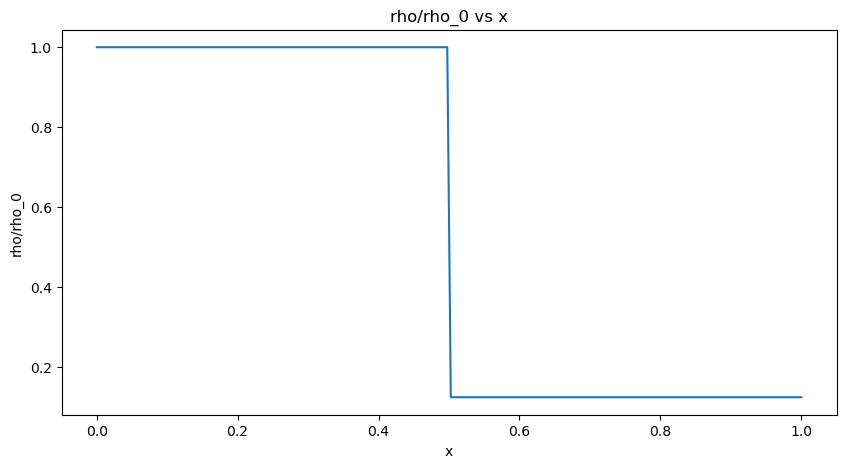

for timestep = 1 at t = 0.0004247006305168397, dt = 0.0004247006305168397
for timestep = 2 at t = 0.0006629532024393819, dt = 0.0002382525719225422
for timestep = 3 at t = 0.0008774703026287761, dt = 0.00021451710018939422
for timestep = 4 at t = 0.0010804918593153969, dt = 0.0002030215566866207
for timestep = 5 at t = 0.0012768146345373725, dt = 0.00019632277522197566
for timestep = 6 at t = 0.0014689166068355148, dt = 0.00019210197229814214
for timestep = 7 at t = 0.0016582697988012586, dt = 0.00018935319196574372
for timestep = 8 at t = 0.0018458261524551386, dt = 0.00018755635365387994
for timestep = 9 at t = 0.002032236969616439, dt = 0.00018641081716130027
for timestep = 10 at t = 0.002217965699231448, dt = 0.00018572872961500906
for timestep = 11 at t = 0.0024033514924922525, dt = 0.00018538579326080455
for timestep = 12 at t = 0.002588647582352501, dt = 0.00018529608986024866
for timestep = 13 at t = 0.0027740457480476236, dt = 0.00018539816569512247
for timestep = 14 at t = 0.

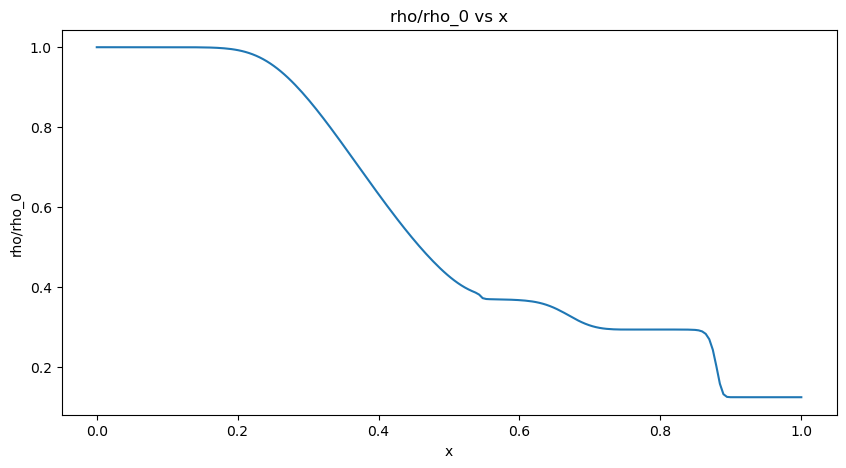

In [1090]:
Ufinal = sodshockmain()
# Initial condition is good
# After 1 time step, the first ghost cells are all NaN's. 
# After adding U = FillSodShockBCs(U,Ni,Nj), the next time step, it becomes 1's except at the boundary
# Density becomes zero at the boundary, and then the first two columns become NaN except for those zero values.
# What is filling those zero values in the last two columns? Even without filling the BC's, these are becoming zero.
# What is filling the zero values in the bottom row? Even without the BC filling, these become zero.

# After some investigation, I have found that R is zero at all points, which is not good.
# Something is wrong with the flux vector splitting, particularly in the pressure/energy term
# pressure/energy is the only one that should be different and have a non-zero R at the pressure discontinuity.

# However, even though R is zero, somehow the last two columns of U are becoming zero.
# Additionally, the bottom two rows are also becoming zero.

# To diagnose this error, let's try a much sparser grid: 2x2 interior.

# After defining c = sqrt(gamma*P/rho), we no longer get NaN values. However, the density does become negative.
# This is clearly incorrect, and something else is clearly wrong with the flux splitting.
# I should try the simpler flux splitting, just to make sure that everything else is working properly.

# Here, the result is valid, but the shape is wrong. I think the wave needs to propagate faster.
# Need to check that my flux splitting is correct, and double check my explicit euler.

# Now I get a maximum stable explicit time step of 135, which is clearly wrong. lmi should be larger than 0.075 -- 

In [1058]:
testmatr = np.array([0, 1, 2])
print(testmatr)
testmatr[1:3]

[0 1 2]


array([1, 2])

# Elliptical Airfoil Problem

Most of the machinery we built for the sod shock tube will be valid. However, we will need to remake:
- mesh generation function for ellipse, with clustering near wall for lower y+
- break out mesh metrics calculation function and mesh generation function for general use, swappability
- Understand nondimensional initialization, global variables
- Determine what the global initialization should be (initialize to free-stream)
- Make new function to fill boundary conditions for curvilinear grid with airfoil...
- Make functions valid for variable delta xi, delta eta, not equal to 1? Either that, or account for the fact that these values are discrete in my calculations for the mesh generation... 2pi * xi / max(xi) where max(xi) = numxint-1
- Create new grid parameters (such as L, H, dx, dy)

# Elliptical Grid Generation Function

Want to get 50 chord lengths away from the airfoil.
$\xi$ represents the angle, $\eta$ represents the radial distance from the origin. Since $\xi$ should nominally range from 0 to $2\pi$, but I want to use a step size of 1 for $\xi$ to reduce the complexity of passing $\Delta\xi$ values through all my functions, I choose to use $\xi$ as angle/$(2*\pi*max(\xi))$ so that I can still use a step size of 1 for both $\xi$ and $\eta$. 

WRAP THE MESH CLOCKWISE!!!!! MAKE SURE THIS HAPPENS!!!
- Was it clockwise? Can't quite remember.... I suppose I'll find out when I get there

MAKE SURE THAT THE GHOST CELLS ARE FILLED APPROPRIATELY SO THAT THE DERIVATIVES OF XI AND ETA AT THE CUT THRU THE MESH ARE REASONABLE
- WRAP ALL VALUES xi, eta, before computing derivatives

START ETA AT SOME VALUE GREATER THAN 0 SO THAT I DON'T START AT THE CIRCLE RADIUS 1?? Jacobian contour is very small!!!

LEARN HOW TO PLOT THE MESH ITSELF RATHER THAN JUST THE JACOBIAN CONTOURS!!!

[[ 192.36829716  155.62922158   59.445073    -59.445073   -155.62922158
  -192.36829716 -155.62922158  -59.445073     59.445073    155.62922158
   192.36829716  155.62922158]
 [  70.78886798   57.26939721   21.87496322  -21.87496322  -57.26939721
   -70.78886798  -57.26939721  -21.87496322   21.87496322   57.26939721
    70.78886798   57.26939721]
 [  26.09756553   21.11337402    8.06459126   -8.06459126  -21.11337402
   -26.09756553  -21.11337402   -8.06459126    8.06459126   21.11337402
    26.09756553   21.11337402]
 [   9.75242798    7.88987998    3.01366598   -3.01366598   -7.88987998
    -9.75242798   -7.88987998   -3.01366598    3.01366598    7.88987998
     9.75242798    7.88987998]
 [   4.            3.23606798    1.23606798   -1.23606798   -3.23606798
    -4.           -3.23606798   -1.23606798    1.23606798    3.23606798
     4.            3.23606798]]
[[ 0.00000000e+00  3.71132646e+01  6.00505235e+01  6.00505235e+01
   3.71132646e+01  7.73252485e-15 -3.71132646e+01 -6.00505

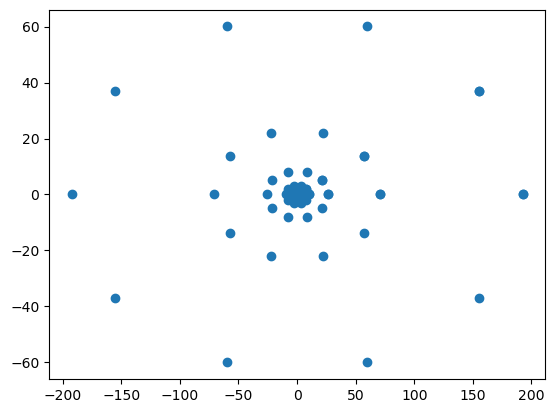

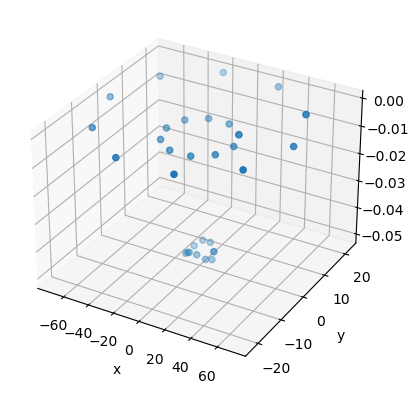

<Figure size 640x480 with 0 Axes>

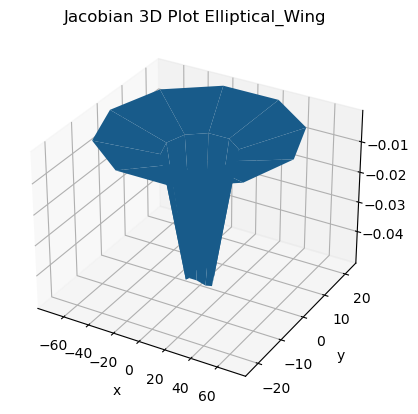

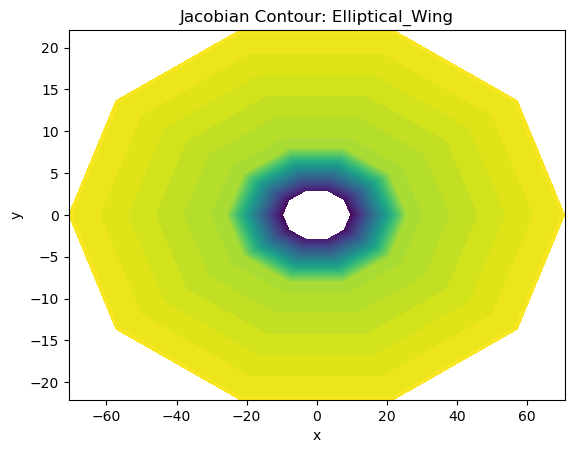

-------


In [1248]:
def ellipticalgridgen(numxiint,numetaint,numghosts): 
    # numxint is the number of internal points in i. Number of intervals is numpts-1.
    # numyint is the number of internal points in j. Number of intervals is numpts-1.
    
    # This calculation is copied in main() rather than passing more info to the function
    # Probably a bad design decision, make these inputs to the function
    # total number of points in each direction
    Ni = numxiint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    Nj = numetaint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    
    dxi = 1
    deta = 1
    
    xi = np.zeros((Nj,Ni))
    eta = np.zeros((Nj,Ni))
    for i in range(0,Ni,dxi): # from 0 to Ni with step size 1. 
        for j in range(0,Nj,deta): # from 0 to Nj with step size 1
            xi[j,i] = i
            eta[j,i] = Nj-j
    # The reason I use two for loops instead of np.arange 
    # is that I don't want to write a for loop to copy one vector many times, since xi and eta are the same.
    # This is inefficient storage-wise, but it works nicely to make all the data have the same 2D format.
    
    x = 4/math.cosh(1)*np.cosh(eta)*np.cos(2*math.pi*xi/(np.amax(xi)-1)) #(xi-numghosts)*dx # for this particular mesh, where x=xi (but then subtract the ghosts)
    y = np.sinh(eta)/math.sinh(1)*np.sin(2*math.pi*xi/(np.amax(xi)-1)) #(eta-numghosts)*dy # y=eta (but subtract the ghosts)
    print(x)
    print(y)
    
#     print(xi/np.amax(xi))
#     print(eta)
#     print(x)
#     print(y)
    
    coords = np.zeros((Nj,Ni,9)) # Nj rows, Ni columns, 9 layers
    coords[:] = np.nan
    # coords[:] = 27
    # Note that any value that is not filled will default to zero. 
    # This can be dangerous, so I fill all the unused values with NaN's
    
    # coords[0:Nj,0:Ni,0] = x
    coords[:,:,0] = x 
    coords[:,:,1] = y
    coords[:,:,2] = xi
    coords[:,:,3] = eta
    # Note that this includes values of coordinates for the ghost cells
    
    coords = meshmetrics(numxiint,numetaint,numghosts,coords) #note that the slice indexing excludes the last value

    # coords contains an array for each of x, y, xi, and eta, and derivatives of xi and eta. 
    # Each specific value can be accessed by indices i,j.
    # For x, coords[j,i,0]=xval, coords[j,i,1] = yval, coords[j,i,2]=xival, coords[j,i,3]=etaval.
    # coords[j,i,4] = dxidx, coords[j,i,5] = detadx, coords[j,i,6] = dxidy, coords[j,i,7] = detady, coords[j,i,8] = J
    
    J = coords[:,:,8]
    
    # Plot grid
    plt.figure()
    plt.scatter(x,y)
    plt.show()
    PlotJacobian(x,y,J,levels=50,filename='Elliptical_Wing')
    
    return coords

ellipticalgrid = ellipticalgridgen(numxiint=10,numetaint=3,numghosts=1)
# For sod shock tube, L = 4.5. H = 1 for arbitrary convenience, dx = 1.0
# Note that x=1.95 is the boundary between points. Potentially want to make it so no points lie there?
# x=1.95 is halfway between points? 


# sodshockgrid(j, i, quantity index)
x = ellipticalgrid[0:Nj,0:Ni,0]
# print(x) # x
y = ellipticalgrid[0:Nj,0:Ni,1]
# print(y) #y
# print(ellipticalgrid[:,:,2]/(np.amax(ellipticalgrid[:,:,2])-1)) #xi
# print(ellipticalgrid[:,:,3]) # eta
# print(ellipticalgrid[:,:,4]) # dxidx
# print(ellipticalgrid[:,:,5]) # detadx
# print(ellipticalgrid[:,:,6]) # dxidy
# print(ellipticalgrid[:,:,7]) # detady
J = ellipticalgrid[0:Nj,0:Ni,8]
# print(J) # J




print('-------')

# MAKE A PLOT OF JACOBIAN


# Note that Pramod only did ghost cells on one side of the solution in x
# He said you could get away with no ghost cells in x, but that adding them on one side was more stable
# Should I try this? If I get bad results, I will try it...

In [1242]:
print(np.cosh(1))
print(math.cosh(1))
print(np.sinh(1))
print(math.sinh(1))

1.5430806348152437
1.5430806348152437
1.1752011936438014
1.1752011936438014


# Code Graveyard (in case I need any of this stuff later)

In [ ]:

def get_dFdxi(U):
    # This takes in the 3D array U and returns a 3d array, the 1D vector dFdxi at all points in 2D mesh
    dFdxi = np.full_like(U,0)
    for i in np.shape(U)[0]: # NEED TO EXCLUDE THE GHOST CELLS
        for j in np.shape(U)[1]: # NEED TO EXCLUDE THE GHOST CELLS
            Fpl = fluxpm('F','plus',U[i,j],smoothing=True)
            Flopl = fluxpm('F','plus',U[i-1,j],smoothing=True)
            Fhimi = fluxpm('F','minus',U[i+1,j],smoothing=True)
            Fmi = fluxpm('F','minus',U[i,j],smoothing=True)
            # ADD IN COMPUTATION OF FTILDE, GTILDE
            dFdxi[i,j,:] = (Fpl - Flopl) + (Fhimi - Fmi)
            # NOTE THAT I ASSUME DELTA XI IS 1
    return dFdxi

def get_dGdeta(U):
    # This takes in the 3D array U and returns a 3d array, the 1D vector dGdxi at all points in 2D mesh
    dGdeta = np.full_like(U,0)
    for i in np.shape(U)[0]: # NEED TO EXCLUDE THE GHOST CELLS
        for j in np.shape(U)[1]: # NEED TO EXCLUDE THE GHOST CELLS
            Gpl = fluxpm('G','plus',U[i,j],smoothing=True)
            Glopl = fluxpm('G','plus',U[i-1,j],smoothing=True)
            Ghimi = fluxpm('G','minus',U[i+1,j],smoothing=True)
            Gmi = fluxpm('G','minus',U[i,j],smoothing=True)
            # ADD IN COMPUTATION OF FTILDE, GTILDE
            dGdeta[i,j,:] = (Gpl - Glopl) + (Ghimi - Gmi)
            # NOTE THAT I ASSUME DELTA ETA IS 1
    return dGdeta
